El dataset se puede descargar de Kaggle dando click [aquí](https://www.kaggle.com/datasets/surajjha101/stores-area-and-sales-data).

Este dataset se compone de las siguientes columnas.

- **Store ID**: ID de una tienda particular.
- **Store_Area**: Área de la tienda en yardas.
- **Items_Available**: Número de items disponibles en la tienda.
- **Daily_Customer_Count**: Número de clientes que visitaron la tiendas en promedio durante el mes.
- **Store_Sales**: Venta en dólares hecha por la tienda.

Y el **objetivo** es *estudiar cómo mejorar las ventas*.

## Librerías requeridas y carga de dataset

In [133]:
# Manipulación
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot

# Modelamiento
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [63]:
df = pd.read_csv("Stores.csv")

In [23]:
df.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,1,1659,1961,530,66490
1,2,1461,1752,210,39820
2,3,1340,1609,720,54010
3,4,1451,1748,620,53730
4,5,1770,2111,450,46620


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Store ID              896 non-null    int64
 1   Store_Area            896 non-null    int64
 2   Items_Available       896 non-null    int64
 3   Daily_Customer_Count  896 non-null    int64
 4   Store_Sales           896 non-null    int64
dtypes: int64(5)
memory usage: 35.1 KB


### Pequeños cambios que se pueden realizar desde ya

In [64]:
# Store ID contiene espacio en blanco al final
# Se eliminan todos los espacios antes o después en los nombres de columna
df.columns = [col.strip() for col in df.columns]

In [26]:
# Verificando que la columna Store ID se puede usar como índice
df['Store ID'].compare(pd.Series(np.arange(1,897,1)))

,self,other


In [65]:
df.set_index('Store ID', inplace=True)

In [66]:
# Store_Area, Store_Sales son continuas
df[['Store_Area', 'Store_Sales']] = df[['Store_Area', 'Store_Sales']].astype('float')

In [67]:
# Yardas^2 a metros^2
df['Store_Area'] = df['Store_Area']*0.9144**2 

# EDA

In [31]:
df.describe()

,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
count,896.000000,896.000000,896.000000,896.000000
mean,1241.991606,1782.035714,786.350446,59351.305804
std,209.230011,299.872053,265.389281,17190.741895
min,647.998704,932.000000,10.000000,14920.000000
25%,1100.970701,1575.500000,600.000000,46530.000000
50%,1234.960111,1773.500000,780.000000,58605.000000
75%,1382.536590,1982.750000,970.000000,71872.500000
max,1863.727885,2667.000000,1560.000000,116320.000000


Sobre las ventas:
- Promedian aprox. en los 60 mil dólares.
- Tiene leve sesgo a derecha.
- No se tiene conocimiento el período de tiempo para contabilizar ventas.

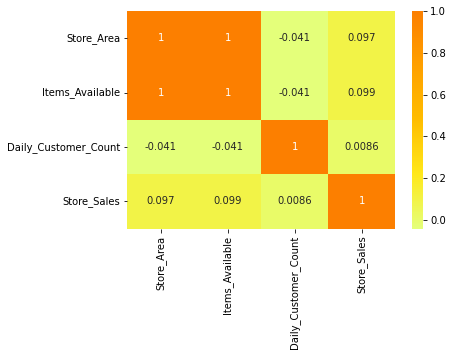

In [33]:
# Correlaciones
corr = df.corr()
sns.heatmap(data=corr, cmap='Wistia', annot=True)
plt.show()

- No es sorprendente la fuerte relación entre *Store_Area* y *Items_Available*. La idea en una tienda es ofrecer tanto como se pueda.

- La relación entre *Daily_Customer_Count* y *Store_Sales* no es clara.

- Es de notarse de la relación de *Daily_Customer_Count* y *Items_Available* que entre más clientes, menos items disponibles habrá.

- No resulta intuitivo que entre más clientes (*Daily_Customer_Count*), menor sea el área de la tienda (*Store_Area*).

Surge una pregunta que no sé si sea posible aclarar con la información disponible: ¿Son el conteo de productos todos items diferentes?

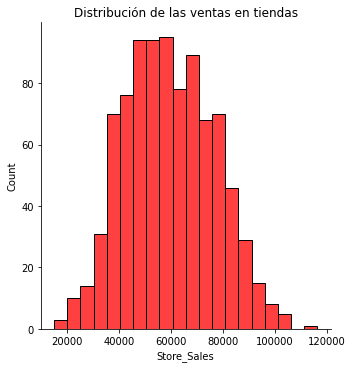

In [37]:
sns.displot(df['Store_Sales'], color='r')
plt.title('Distribución de las ventas en tiendas')
plt.show()

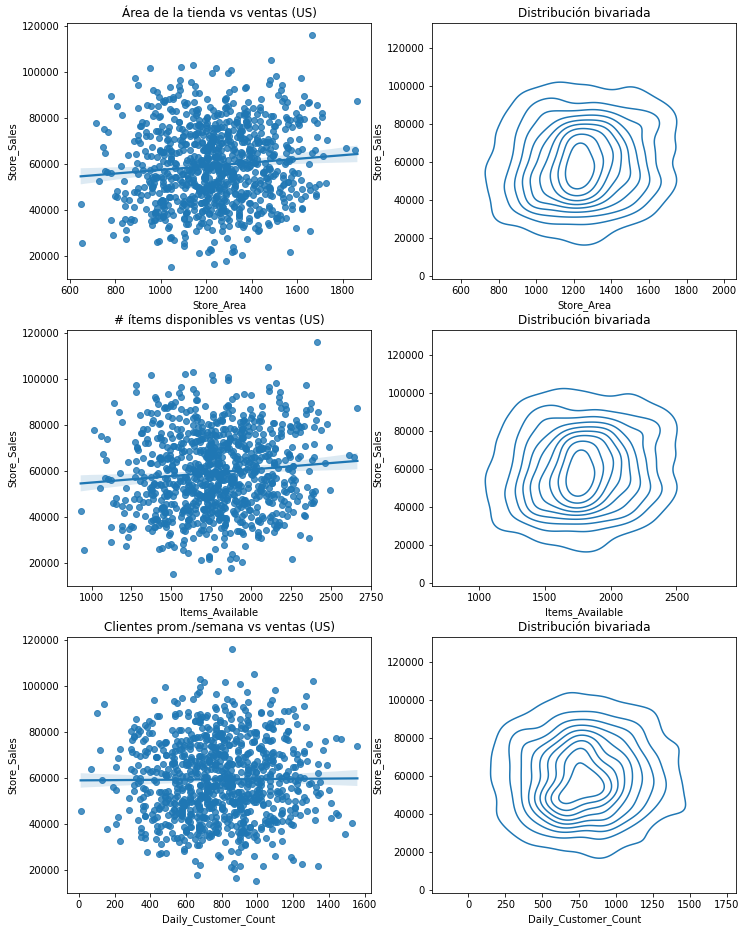

In [58]:
# Regresión lineal de ventas versus el resto de variables
f = plt.figure(figsize=(12,16))

ax = f.add_subplot(321)
sns.regplot(x='Store_Area', y='Store_Sales', data=df)
ax.set_title('Área de la tienda vs ventas (US)')

ax = f.add_subplot(322)
sns.kdeplot(data=df, x="Store_Area", y="Store_Sales")
ax.set_title('Distribución bivariada')

ax = f.add_subplot(323)
sns.regplot(x='Items_Available', y='Store_Sales', data=df)
ax.set_title('# ítems disponibles vs ventas (US)')

ax = f.add_subplot(324)
sns.kdeplot(data=df, x="Items_Available", y="Store_Sales")
ax.set_title('Distribución bivariada')

ax = f.add_subplot(325)
sns.regplot(x='Daily_Customer_Count', y='Store_Sales', data=df)
ax.set_title('Clientes prom./semana vs ventas (US)')

ax = f.add_subplot(326)
sns.kdeplot(data=df, x="Daily_Customer_Count", y="Store_Sales")
ax.set_title('Distribución bivariada')

plt.show()

In [118]:
X = df.drop(columns='Store_Sales')
y = df['Store_Sales'].copy()

## Dividir la data en entrenamiento y validación

In [125]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=0
)

## Modelos supervisados

La idea que se intentará plasmar es encontrar regiones con altas ventas luego de encontrar los modelos y encontrar aquellas características que influyen más en un gradiente estocástico para dar consejos a partir de éstos.

### Regresión lineal

Es un algoritmo de aprendizaje supervisado empleado cuando la variable objetivo es continua. Trabaja empleando el error medio cuadrático (MSE, también es lo mismo que las siglas OLS). El MSE minimiza la suma de los cuadrados de las diferencias entre la observación y la predicción. 

Supone que las variables predictoras son independientes.

In [121]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [122]:
y_pred = lr.predict(X_valid)
mse = mean_squared_error(y_pred, y_valid)
print('El error medio cuadrático es: {}'.format(mse))

El error medio cuadrático es: 275058660.3135971


Es un MSE muy malo. Probemos con árboles de decisión.

### Árboles de decisión

In [123]:
dtr= DecisionTreeRegressor(random_state=0)
dtr.fit(X_train,y_train)

DecisionTreeRegressor(random_state=0)

In [124]:
y_pred = dtr.predict(X_valid)
mse = mean_squared_error(y_pred, y_valid)
print('El error medio cuadrático es: {}'.format(mse))

El error medio cuadrático es: 595282216.1111112


Tampoco resulta adecuado.

### KNN Regresión

In [128]:
# Instanciar y entrenar
knn_model = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)

# Score
score_knn = knn_model.score(X_valid, y_valid)
score_knn

-0.31554293780843334

Recordar que el **score** es el coeficiente de determinación de la predicción.

El coeficiente de determinación $R^2$ es definido como $\left(1-\frac{u}{v}\right)$, donde $u=\sum\left(y-\hat{y}\right)^2$ y $v=\sum\left(y-\bar{y}\right)^2$.

El mejor score es 1. Puede ser negativo porque el modelo puede ser arbitrariamente malo.

Significa que este modelo no está funcionando bien.

In [131]:
# Predicciones
preds = knn_model.predict(X_valid)

# Desempeño
performance = pd.DataFrame({ 'Verdadero valor': y_valid,
                            'Prediccion': preds,
                            'Error': y_valid - preds})
performance.describe()

,Verdadero valor,Prediccion,Error
count,180.000000,180.000000,180.000000
mean,58350.000000,59800.000000,-1450.000000
std,16724.899846,7585.293681,19127.791755
min,14920.000000,37324.000000,-43296.000000
25%,46957.500000,55211.000000,-15076.500000
50%,56235.000000,59788.000000,-1824.000000
75%,69250.000000,65103.500000,11177.500000
max,102310.000000,77184.000000,55820.000000


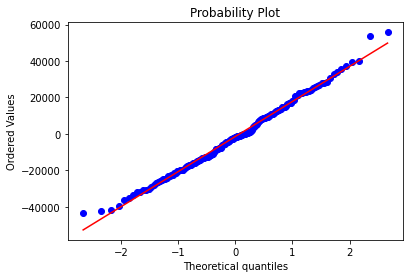

In [134]:
#QQ Plot
probplot(performance['Error'], dist='norm', plot=plt);

## Modelos no supervisados

- ¿Qué características tienen las tiendas que venden más? Esta puede ser una línea de investigación interesante. Si se logran identificar esas cosas que hace que las tiendas imiten a las mejores tiendas en ventas, se podrían dar ciertas recomendaciones.
- También se puede construir un modelo predictivo para las ventas de la tienda. Serían a lo sumo sólo 3 variables predictoras. Se podría construir el modelo predictivo y luego optimizar en el espacio de búsqueda. Una vez encontradas regiones de óptimos, 